# Set Variables

In [1]:
label1_th = 0.7
number_of_chunks = 3

# -------- outp_version
output_version = 1052


# -------- method: first
which_method = "first"
# which_method = "second"
# which_method = "third"

if (which_method == "first" or which_method == "third"):
    class_percentage = 0.5 # predictable classes (a)

if (which_method == "second" or which_method == "third"):
    top_k = 20


# -------- method_way
method_way = "c" # a, b, c

if (method_way == "a" and (not which_method == "first")):
    bug_localization_accuracy = [1] # main data - th
    knn_accuracy_threshold =    [1]

if method_way == "b":
    bug_localization_accuracy = [1] # main data - th
    knn_accuracy_threshold = [
        0.5, 0.55, 
        0.6, 0.65, 
        0.7, 0.75, 
        0.8, 0.85, 
        0.9, 0.95
    ]

if method_way == "c":
    bug_localization_accuracy = [0.4]
    knn_accuracy_threshold = [
        0.5, 0.55, 
        0.6, 0.65, 
        0.7, 0.75, 
        0.8, 0.85, 
        0.9, 0.95
    ]


# -------- dataset
software_name = "camel"
# software_name = "cloudstack"
# software_name = "HBase"


# -------- google colab
# on_google_colab = True
on_google_colab = False

In [2]:
print("bla: ", bug_localization_accuracy)
print("th:  ", knn_accuracy_threshold)

bla:  [0.4]
th:   [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


# Google Colab

In [3]:
if software_name == "HBase":
    dataset_file_name = "dataset_hbase - v.03"
    dataset_file_name_ts = "timeserAll - v.03"

elif software_name == "camel":
    dataset_file_name = "dataset_camel - v.01"
    dataset_file_name_ts = "timeserAll_camel - v.01"
else:
    dataset_file_name = "cloudstack_bugs - v.01"
    dataset_file_name_ts = "cloudstack_TimeSeries - v.01"

In [4]:
if on_google_colab:
    
    !pip install enlighten
    !pip install --upgrade statsmodels 
    !pip install --upgrade matplotlib
    
    # load data from google drive
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    !ls "/content/gdrive/My Drive/"
    
    tempPre = "gdrive/MyDrive/Colab Notebooks/paper/Indirect Method/"
    pre_path_data = tempPre + "data/" + software_name + "/"
    
    # you can choose one of these and comment out the other:
    # pre_path_output = tempPre + "output/"
    pre_path_output = tempPre + "output/" + dataset_file_name + "/" + which_method + "/"

else:
    tempPre =    "E:/darsy/00/02- arshad/10- paper code/"
    tempData =   "00- My Data/Datasets/Indirect Method/"
    tempOutput = "01- Jupyter Notebook/InDirect Method/00. Output/"
    pre_path_data =   tempPre + tempData   + software_name + "/"
    pre_path_output = tempPre + tempOutput + software_name + "/" + dataset_file_name + "/" + which_method + "/"

# Libs

In [5]:
import random 
import json
import math
import os

import enlighten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import truediv
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.neighbors import KNeighborsClassifier

In [6]:
import warnings
warnings.filterwarnings("ignore")

# Config

In [7]:
mypaths = {
    "dataset": pre_path_data + dataset_file_name    + ".csv", 
    "timeser": pre_path_data + dataset_file_name_ts + ".csv", 
    "output_performance": pre_path_output + "performance-v{}.json".format(output_version), 
    "split_dataset": pre_path_output
}

preprocessing_params = {
    "dataset": {
        # time_stamp is the time that we change the class for a bug fixing.
        # id stands for identifier
        "columns_name":   ["bug_report_id", "class_id", "time_stamp", "label"],
        "columns_dtype" : {0: "int64", 1: "int64", 2: "int64", 3:"int32"}
    },
    
    "timeser": {
        "columns_name":   ["class_id", "time_stamp", "label"],
        "columns_dtype" : {0: "int64", 1: "int64", 2:"int32"}
    },
    
    # 0: no change | 1: increase bad smell | -1: decrease bad smell
    "class_labels": [0, 1, -1], 
    "num_classes": 3,
    "bc2_labels": [0, 1],
    "bc2_num_classes": 2,
    "top_k": None,
    "class_percentage": None,
    "label1_th": label1_th,
}

if (which_method == "first" or which_method == "third"):
    preprocessing_params["class_percentage"] = class_percentage

if (which_method == "second" or which_method == "third"):
    preprocessing_params["top_k"] = top_k
    
    

knn_model_params = {
    "train_size": 0.8,
    "n_neighbors": 5
}

progress_colours = ["webmaroon", "salmon", "orangered", "deeppink3", "crimson", 
                    "black", "blue", "gray", "cyan4", "darkgreen"]

# CalculateMetrics

In [8]:
class CalculateMetrics():
    def __init__(self, cm):
        self.cm = cm
        self.true_positives = np.diag(cm)
    
    
    # calculate precision for each class
    def calc_precision(self):
        columns_sum = np.sum(self.cm, axis=0)
        prec = list(map(truediv, self.true_positives, columns_sum))
        self.precision = prec
        return prec
    
    
    # calculate recall for each class
    def calc_recall(self):
        rows_sum = np.sum(self.cm, axis=1)
        rec = list(map(truediv, self.true_positives, rows_sum))
        self.recall = rec
        return rec
    
    
    # calculate f1_score for each class
    def calc_f1_score(self):
        tempPrec = np.array(self.precision)
        tempRec = np.array(self.recall)
        numerator = tempPrec * tempRec
        Denominator = tempPrec + tempRec
        f1s = 2 * (numerator / Denominator)
        self.f1_score = f1s
        return f1s

# Plot results

In [9]:
ls = "solid"
lw = 1
marker = "."
colours = {
    "simple": "red",
    "bc_2":   "blue",
}

## load_results

In [10]:
print(mypaths["output_performance"])
with open(mypaths["output_performance"]) as filehandle:
    whole_data = json.load(filehandle)

E:/darsy/00/02- arshad/10- paper code/01- Jupyter Notebook/InDirect Method/00. Output/camel/dataset_camel - v.01/first/performance-v1052.json


In [11]:
bla = whole_data["bug_localization_accuracy"]
threshold = whole_data["knn_accuracy_threshold"]
samples_num = whole_data["samples_num"]
samples_num_pred = whole_data["samples_num_pred"]
brIDs_num = whole_data["brIDs_num"]
brIDs_num_pred = whole_data["brIDs_num_pred"]

cf = whole_data["confusion_matrix"]

nplot = len(threshold)

df_data_bug_class_distribution = whole_data["df_data_bug_class_distribution"]

In [12]:
def y_th_():
    return {th: [] for th in threshold}

In [13]:
df = pd.DataFrame({
    "bla":              pd.Series(dtype="float64"),
    "th":               pd.Series(dtype="float64"),
    "samples_num_pred": pd.Series(dtype="int64"),
    "samples_percent":  pd.Series(dtype="int32"),
    "brIDs_num_pred":   pd.Series(dtype="int64"),
    "brIDs_percent":    pd.Series(dtype="int32")
})

y_values = {
    "simple": y_th_(),
    "bc_2":   y_th_(),
}

## confusion_matrices

--------------- bla: 0.4, th: 0.5
precision:  [0.79, 0.33]
recall:     [0.92, 0.14]
f1_score:   [0.85, 0.19]
--------------- bla: 0.4, th: 0.55
precision:  [0.79, 0.32]
recall:     [0.92, 0.13]
f1_score:   [0.85, 0.19]
--------------- bla: 0.4, th: 0.6
precision:  [0.8, 0.29]
recall:     [0.93, 0.1]
f1_score:   [0.86, 0.15]
--------------- bla: 0.4, th: 0.65
precision:  [0.8, 0.28]
recall:     [0.93, 0.1]
f1_score:   [0.86, 0.15]
--------------- bla: 0.4, th: 0.7
precision:  [0.8, 0.19]
recall:     [0.94, 0.06]
f1_score:   [0.87, 0.09]
--------------- bla: 0.4, th: 0.75
precision:  [0.82, 0.26]
recall:     [0.95, 0.07]
f1_score:   [0.88, 0.12]
--------------- bla: 0.4, th: 0.8
precision:  [0.83, 0.2]
recall:     [0.97, 0.04]
f1_score:   [0.89, 0.07]
--------------- bla: 0.4, th: 0.85
precision:  [0.83, 0.0]
recall:     [0.97, 0.0]
f1_score:   [0.89, nan]
--------------- bla: 0.4, th: 0.9
precision:  [0.83, 0.0]
recall:     [0.98, 0.0]
f1_score:   [0.9, nan]
--------------- bla: 0.4, th

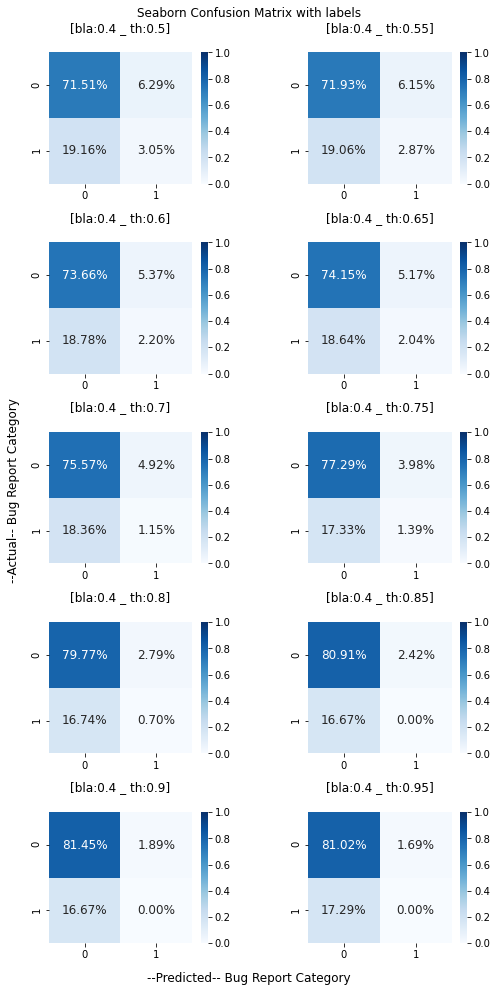

In [24]:
no_rows = round(len(threshold) / 2)
fig_cf, axes_cd = plt.subplots(nrows=no_rows, ncols=2, figsize=(7, 14))
fig_cf.suptitle("Seaborn Confusion Matrix with labels")
fig_cf.supxlabel("--Predicted-- Bug Report Category")
fig_cf.supylabel("--Actual-- Bug Report Category")

i = 0

my_row = 0
my_col = 0
for b in bla:
    for j, th in enumerate(threshold):
        cfax = axes_cd[my_row][my_col]
        mycbar = True
#             if datasetName == "train":
#                 mycbar = True
#             else:
#                 mycbar = False

        cf_matrix = cf[str(b)][str(th)]["confusion_matrix"]
        cf_matrix = np.array(cf_matrix)

        calcmet = CalculateMetrics(cf_matrix)
        precision = calcmet.calc_precision()
        precision = [round(elem, 2) for elem in precision]

        recall = calcmet.calc_recall()
        recall = [round(elem, 2) for elem in recall]

        f1_score = calcmet.calc_f1_score()
        f1_score = [round(elem, 2) for elem in f1_score]

        print("-" * 15, "bla: {}, th: {}".format(b, th))
        print("precision: ", precision)
        print("recall:    ", recall)
        print("f1_score:  ", f1_score)

        snax = sns.heatmap(cf_matrix / np.sum(cf_matrix), 
                           annot=True, fmt=".2%", cmap="Blues", ax=cfax, vmin=0, vmax=1, 
                           cbar=mycbar, annot_kws={"size": 12})


        snax.set_title("[bla:{} _ th:{}]\n".format(b, th))


        labels = list(map(str, [0, 1]))

        snax.xaxis.set_ticklabels(labels)
        snax.yaxis.set_ticklabels(labels)
        i += 1
        
        if (j % 2 != 0):
            my_row += 1
            my_col = 0
        else:
            my_col = 1

fig_cf.tight_layout(w_pad=6.0)

In [15]:
for sub_bla in bla:
    print("**bla=", sub_bla)
    for th in threshold:
        temp = samples_num_pred[str(sub_bla)][str(th)] / samples_num
        temp = temp * 100
        print(th, round(temp, 1))
    print("-" * 10)

**bla= 0.4
0.5 1.6
0.55 1.5
0.6 1.3
0.65 1.2
0.7 1.0
0.75 0.9
0.8 0.8
0.85 0.7
0.9 0.6
0.95 0.6
----------


In [16]:
for sub_bla in bla:
    print("**bla=", sub_bla)
    for th in threshold:
        temp = brIDs_num_pred[str(sub_bla)][str(th)] / brIDs_num
        temp = temp * 100
        print(th, round(temp, 1))
    print("-" * 10)

**bla= 0.4
0.5 11.3
0.55 10.8
0.6 9.1
0.65 8.1
0.7 6.8
0.75 5.6
0.8 4.8
0.85 4.1
0.9 3.5
0.95 3.3
----------


In [ ]:
def set_title_(th_gname):
    tempstr = "-" * 5
    my_title = tempstr + " KNN Accuracy Threshold: " + str(th_gname) + " " + tempstr
    return my_title

## plot_acc | linear plot

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

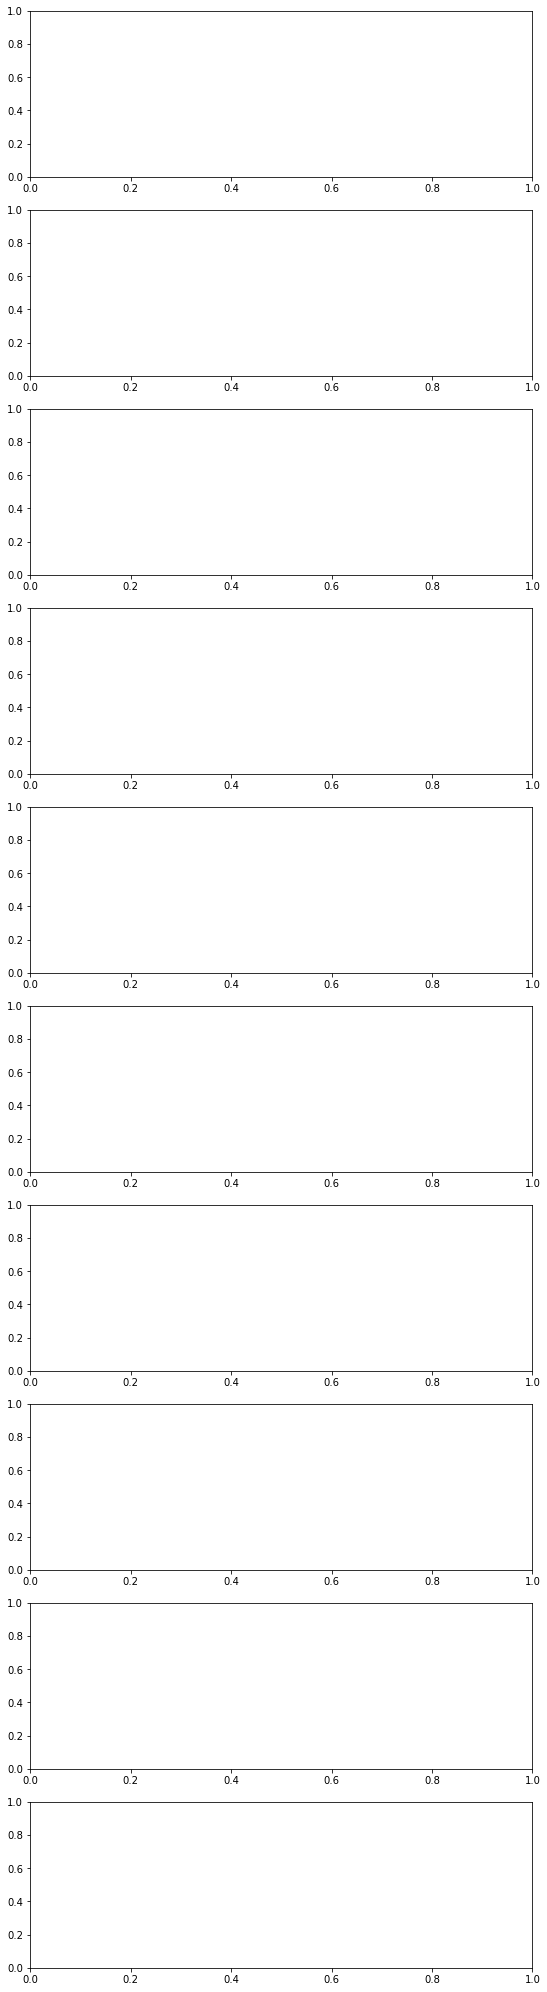

In [26]:
my_fig_height = 18
temp1 = my_fig_height / 5
temp2 = temp1 * nplot
# figsize=(a, b) : a_width, b_height
fig, axes = plt.subplots(nrows=nplot, ncols=1, figsize=(9, temp2))
if nplot == 1:
    axes = [axes]

for ax, th in zip(axes, threshold):
    for key, value in y_values.items():
        ax.plot(bla, 
                value[th], 
                label=key, 
                color=colours[key], 
                linestyle=ls, 
                lw=lw, 
                marker=marker)

    ax.set_title(set_title_(th))
    ax.set_xlabel("Bug Localization Accuracy")
    ax.set_ylabel("Total accuracy")

    ax.set_xlim([0.45, 1.05])
    ax.get_xaxis().set_ticks(bla)

    ax.set_ylim([0, 110])
    ax.get_yaxis().set_ticks(list(range(0, 101, 10)))

    ax.legend()
    ax.grid(True)
# --- end for

fig.tight_layout(pad=3.0)

In [27]:
def plot_acc(self):
    
    
    
    # --------------------------- plot_percent_num | bar plot
    
    def plot_percent_num(self):
        my_fig_height = 18
        temp1 = my_fig_height / 5
        temp2 = temp1 * self.nplot
        fig, axes = plt.subplots(nrows=self.nplot, ncols=1, figsize=(9, temp2))
        if self.nplot == 1:
            axes = [axes]
        self.counter = 0
        self.df.groupby("th").apply(lambda g: self.plot_flow_percent_(g, axes[self.counter]))
        fig.tight_layout(pad=3.0)
    
    
    def plot_flow_percent_(self, g, ax):
        x_axis = np.arange(len(self.bla))
        width = 0.4
        ax.bar(x_axis - 0.2, g["samples_percent"], width=width, label="Samples", color="#1F77B4") # blue
        ax.bar(x_axis + 0.2, g["brIDs_percent"], width=width, label="Bug Report IDs", color="#FF7F0E") # orange
        
        ax.set_title(self.set_title_(g.name))
        ax.set_xlabel("Bug Localization Accuracy")
        ax.set_ylabel("Percentages (%)")
        
        ax.get_xaxis().set_ticks(x_axis, self.bla)
        
        ax.set_ylim([0, 110])
        ax.get_yaxis().set_ticks(list(range(0, 101, 10)))
        
        ax.legend()
        ax.grid(axis="y")
        
        self.counter += 1
    
    
    # --------------------------- plot_class_distribution
    
    def plot_class_distribution(self):
        for i, bla in enumerate(self.bla):
            for j, th in enumerate(self.threshold):
                key_bla = str(bla)
                key_th = str(th)
                #print(j)
                #print(self.df_data_bug_class_distribution[str(bla)][str(th)]["bug_label_num"])
                tempBP = ClassDistribution(None)
                tempBP.bug_label_num = self.df_data_bug_class_distribution[key_bla][key_th]["bug_class_num"]
                tempBP.bug_label_per = self.df_data_bug_class_distribution[key_bla][key_th]["bug_class_per"]
                tempBP.bug_label_ratio = self.df_data_bug_class_distribution[key_bla][key_th]["bug_class_ratio"]
                tempBP.plot_percent_num(bla, th, self.brIDs_num_pred[key_bla][key_th])

In [ ]:
class PlotResults:
    
    def __init__(self):
        self.ls = "solid"
        self.lw = 1
        self.marker = "."
        self.colours = {
            "simple": "red",
            "bc_2":   "blue",
        }
    
    
    def load_results(self, result_path):
        with open(result_path) as filehandle:
            whole_data = json.load(filehandle)
        self.bla = whole_data["bug_localization_accuracy"]
        self.threshold = whole_data["knn_accuracy_threshold"]
        self.samples_num = whole_data["samples_num"]
        self.samples_num_pred = whole_data["samples_num_pred"]
        self.brIDs_num = whole_data["brIDs_num"]
        self.brIDs_num_pred = whole_data["brIDs_num_pred"]
        
        self.cf = whole_data["confusion_matrix"]
        
        self.nplot = len(self.threshold)
        
        self.df_data_bug_class_distribution = whole_data["df_data_bug_class_distribution"]
        
        self.df = pd.DataFrame({
            "bla":              pd.Series(dtype="float64"),
            "th":               pd.Series(dtype="float64"),
            "samples_num_pred": pd.Series(dtype="int64"),
            "samples_percent":  pd.Series(dtype="int32"),
            "brIDs_num_pred":   pd.Series(dtype="int64"),
            "brIDs_percent":    pd.Series(dtype="int32")
        })
        
        self.y_values = {
            "simple": self.y_th_(),
            "bc_2":   self.y_th_(),
        }
        
        for b in self.bla:
            for th in self.threshold:
                # --- df_samples
                samples_num_pred = whole_data["samples_num_pred"][str(b)][str(th)]
                samples_percent = round((samples_num_pred / self.samples_num) * 100)
                
                brIDs_num_pred = whole_data["brIDs_num_pred"][str(b)][str(th)]
                brIDs_percent = round((brIDs_num_pred / self.brIDs_num) * 100)
                
                self.df = self.df.append(
                    {
                        "bla": b, 
                        "th": th, 
                        "samples_num_pred": int(samples_num_pred), 
                        "samples_percent": int(samples_percent),
                        "brIDs_num_pred": int(brIDs_num_pred), 
                        "brIDs_percent": int(brIDs_percent)
                    }, 
                    ignore_index=True
                )
                
                # --- y_values
                for key, value in self.y_values.items():
                    value[th].append(whole_data["accuracies"][str(b)][str(th)][key])
    
    
    def plot_confusion_matrices(self):
        no_rows = round(len(self.threshold) / 2)
        fig_cf, axes_cd = plt.subplots(nrows=no_rows, ncols=2, figsize=(7, 14))
        fig_cf.suptitle("Seaborn Confusion Matrix with labels")
        fig_cf.supxlabel("--Predicted-- Bug Report Category")
        fig_cf.supylabel("--Actual-- Bug Report Category")
        
        
        i = 0
        
        my_row = 0
        my_col = 0
        for b in self.bla:
            for j, th in enumerate(self.threshold):
                cfax = axes_cd[my_row][my_col]
                mycbar = True
    #             if datasetName == "train":
    #                 mycbar = True
    #             else:
    #                 mycbar = False

                cf_matrix = self.cf[str(b)][str(th)]["confusion_matrix"]
                cf_matrix = np.array(cf_matrix)

                calcmet = CalculateMetrics(cf_matrix)
                precision = calcmet.calc_precision()
                precision = [round(elem, 2) for elem in precision]

                recall = calcmet.calc_recall()
                recall = [round(elem, 2) for elem in recall]

                f1_score = calcmet.calc_f1_score()
                f1_score = [round(elem, 2) for elem in f1_score]

                print("-" * 15, "bla: {}, th: {}".format(b, th))
                print("precision: ", precision)
                print("recall:    ", recall)
                print("f1_score:  ", f1_score)

                snax = sns.heatmap(cf_matrix / np.sum(cf_matrix), 
                                   annot=True, fmt=".2%", cmap="Blues", ax=cfax, vmin=0, vmax=1, 
                                   cbar=mycbar, annot_kws={"size": 12})

                
                snax.set_title("[bla:{} _ th:{}]\n".format(b, th))
                

                labels = list(map(str, [0, 1]))

                snax.xaxis.set_ticklabels(labels)
                snax.yaxis.set_ticklabels(labels)
                i += 1
                
                if (j % 2 != 0):
                    my_row += 1
                    my_col = 0
                else:
                    my_col = 1

        fig_cf.tight_layout(w_pad=6.0)
    
    
    
    def percal_samples(self):
        for bla in self.bla:
            print("**bla=", bla)
            for th in self.threshold:
                temp = self.samples_num_pred[str(bla)][str(th)] / self.samples_num
                temp = temp * 100
                print(th, round(temp, 1))
            print("-" * 10)
    
    
    def percal_brids(self):
        for bla in self.bla:
            print("**bla=", bla)
            for th in self.threshold:
                temp = self.brIDs_num_pred[str(bla)][str(th)] / self.brIDs_num
                temp = temp * 100
                print(th, round(temp, 1))
            print("-" * 10)
    
    
    # --------------------------- helpers
    
    def y_th_(self):
        return {th: [] for th in self.threshold}
    
    
    def set_title_(self, th_gname):
        tempstr = "-" * 5
        my_title = tempstr + " KNN Accuracy Threshold: " + str(th_gname) + " " + tempstr
        return my_title
    
    
    # --------------------------- plot_acc | linear plot
    
    def plot_acc(self):
        my_fig_height = 18
        temp1 = my_fig_height / 5
        temp2 = temp1 * self.nplot
        # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=self.nplot, ncols=1, figsize=(9, temp2))
        if self.nplot == 1:
            axes = [axes]
            
        for ax, th in zip(axes, self.threshold):
            for key, value in self.y_values.items():
                ax.plot(self.bla, 
                        value[th], 
                        label=key, 
                        color=self.colours[key], 
                        linestyle=self.ls, 
                        lw=self.lw, 
                        marker=self.marker)
            
            ax.set_title(self.set_title_(th))
            ax.set_xlabel("Bug Localization Accuracy")
            ax.set_ylabel("Total accuracy")
            
            ax.set_xlim([0.3, 1.05])
            ax.get_xaxis().set_ticks(self.bla)
            
            ax.set_ylim([0, 110])
            ax.get_yaxis().set_ticks(list(range(0, 101, 10)))
            
            ax.legend()
            ax.grid(True)
        # --- end for
        
        fig.tight_layout(pad=3.0)
    
    
    # --------------------------- plot_percent_num | bar plot
    
    def plot_percent_num(self):
        my_fig_height = 18
        temp1 = my_fig_height / 5
        temp2 = temp1 * self.nplot
        fig, axes = plt.subplots(nrows=self.nplot, ncols=1, figsize=(9, temp2))
        if self.nplot == 1:
            axes = [axes]
        self.counter = 0
        self.df.groupby("th").apply(lambda g: self.plot_flow_percent_(g, axes[self.counter]))
        fig.tight_layout(pad=3.0)
    
    
    def plot_flow_percent_(self, g, ax):
        x_axis = np.arange(len(self.bla))
        width = 0.4
        ax.bar(x_axis - 0.2, g["samples_percent"], width=width, label="Samples", color="#1F77B4") # blue
        ax.bar(x_axis + 0.2, g["brIDs_percent"], width=width, label="Bug Report IDs", color="#FF7F0E") # orange
        
        ax.set_title(self.set_title_(g.name))
        ax.set_xlabel("Bug Localization Accuracy")
        ax.set_ylabel("Percentages (%)")
        
        ax.get_xaxis().set_ticks(x_axis, self.bla)
        
        ax.set_ylim([0, 110])
        ax.get_yaxis().set_ticks(list(range(0, 101, 10)))
        
        ax.legend()
        ax.grid(axis="y")
        
        self.counter += 1
    
    
    # --------------------------- plot_class_distribution
    
    def plot_class_distribution(self):
        for i, bla in enumerate(self.bla):
            for j, th in enumerate(self.threshold):
                key_bla = str(bla)
                key_th = str(th)
                #print(j)
                #print(self.df_data_bug_class_distribution[str(bla)][str(th)]["bug_label_num"])
                tempBP = ClassDistribution(None)
                tempBP.bug_label_num = self.df_data_bug_class_distribution[key_bla][key_th]["bug_class_num"]
                tempBP.bug_label_per = self.df_data_bug_class_distribution[key_bla][key_th]["bug_class_per"]
                tempBP.bug_label_ratio = self.df_data_bug_class_distribution[key_bla][key_th]["bug_class_ratio"]
                tempBP.plot_percent_num(bla, th, self.brIDs_num_pred[key_bla][key_th])